In [1]:
import os
import sys
import dotenv

from eolearn.core import (
    FeatureType,
    linearly_connect_tasks,
    EOWorkflow,
    OutputTask,
    SaveTask,
    OverwritePermission
)
from eolearn.io import ImportFromTiffTask
from sentinelhub import BBox, CRS

import matplotlib.pyplot as plt
%matplotlib inline

import geopandas as gpd

root_dir = os.path.abspath('../')
if not root_dir in sys.path: sys.path.append(root_dir)

import eolearn_extras as eolx
from sdb_utils.geo import to_bbox

In [2]:
dotenv.load_dotenv()
data_root_path = os.environ.get('data_root')
data_root_path

'D:/sdb_datasets'

In [8]:
gpd.read_file(os.path.join(data_root_path, 'shapes', 'sdb_puerto_rico_aoi.shp')).total_bounds

array([-67.24112119,  18.14442526, -67.18944271,  18.17335221])

In [3]:
bahamas_aoi_df = gpd.read_file(os.path.join(data_root_path, 'shapes', 'sdb_puerto_rico_aoi.shp')).to_crs('EPSG:32619')

reference_bbox = to_bbox(bahamas_aoi_df)
reference_bbox

BBox(((686070.726989808, 2007089.8880674809), (691518.9369155746, 2010279.913413469)), crs=CRS('32619'))

In [4]:
buffered_geom = gpd.GeoSeries(bahamas_aoi_df.to_crs('EPSG:32619').buffer(400).to_crs('EPSG:4326'))
wide_reference_bbox = to_bbox(gpd.GeoDataFrame({'geometry': buffered_geom}))
wide_reference_bbox

BBox(((-67.24490031798747, 18.1408143598537), (-67.18566231606873, 18.176965870622663)), crs=CRS('4326'))

In [5]:
bathy_feature = (FeatureType.DATA_TIMELESS, 'bathy_data')
import_bahamas = ImportFromTiffTask(
    bathy_feature,
    # I'm using abspath here because some EOLearn tasks don't like mixed forward
    # and backward slashes and abspath usually cleans that up
    os.path.abspath(os.path.join(data_root_path, 'ncei_nos_bag_puerto_rico.tiff'))
)

clip_bathy_band = eolx.raster.ClipBoxTask(bathy_feature, target_bounds=wide_reference_bbox)

reproject_bathy = eolx.raster.ReprojectRasterTask(
    bathy_feature,
    target_resolution=(10, 10),
    target_crs='EPSG:32619',
    masked=False,
)

# the scene is shearing if reproject it to UTM so as we are subsetting anyway we can just
# buffer the aoi bounding box first, reproject it (in the subset as this is faster),
# and clip it again to the actual aoi
clip_bathy_band_hack = eolx.raster.ClipBoxTask(bathy_feature, target_bounds=reference_bbox)

append_bathy_data_mask = eolx.bathybase.AppendBathyTimelessDataMask(
    bathy_feature,
    band_index=0,
    depth_sign_is_negative=True
)

output_path = os.path.abspath(
    os.path.join(data_root_path, 'eopatches', 'puerto_rico_bathy_eop')
)
save_eop = SaveTask(
    output_path,
    overwrite_permission=OverwritePermission.OVERWRITE_PATCH
)

output_label = 'bahamas_bathy_eop'
nodes = linearly_connect_tasks(
    import_bahamas,
    clip_bathy_band,
    reproject_bathy,
    clip_bathy_band_hack,
    append_bathy_data_mask,
    save_eop,
    OutputTask(output_label)
)
workflow = EOWorkflow(nodes)

workflow_result = workflow.execute()
bahamas_bathy_eop = workflow_result.outputs[output_label]

bahamas_bathy_eop

EOPatch(
  data_timeless={
    bathy_data: numpy.ndarray(shape=(319, 544, 1), dtype=float32)
  }
  mask_timeless={
    bathy_data_mask: numpy.ndarray(shape=(319, 544, 1), dtype=uint8)
  }
  bbox=BBox(((686070.726989808, 2007089.913413469), (691510.726989808, 2010279.913413469)), crs=CRS('32619'))
)

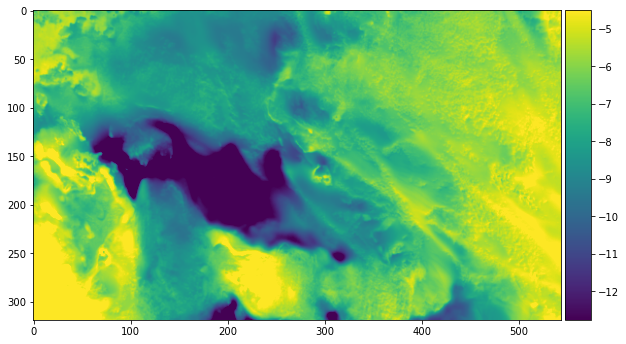

In [6]:
eolx.visualization.plot_single_band(bahamas_bathy_eop, (FeatureType.DATA_TIMELESS, 'bathy_data'), cmap='viridis')
plt.show()